In [128]:
import os, sys
import pickle
from math import floor, ceil
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model as load_keras_model 
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from dataset import Dataset
from database import Database
from sample import Sample

class NeuralNetworkDetector(Database):
    
    __scaler = None
    __model = None
    __history = None
    __input_shape = None
    def __init__(self, dataset_location, database_location, site, transforms, transforms_params):
        self.__transforms = transforms
        self.__transforms_params = transforms_params
        super().__init__(dataset_location, database_location, site)
    
    #########################
    """SAVE AND LOAD MODEL"""
    
    def save_scaler(self, scaler, name=''):
        """Save the scaler used to scale the training data
        Param
            scaler: scaler object
            name: additional name
        """
        print('Saving scaler .... ',end='')
        standard_scaler = {"scaler": scaler}
        scaler_path = os.path.join(self.get_database_location(),self.get_site(),'models',
                                   name+'_'+str(self.__transforms)+'_'+str(self.__transforms_params)+'_scaler.pickle')
        pickle.dump( standard_scaler, open(scaler_path, "wb" ) )
        print('Done.')

    def save_history(self, history, name=''):
        """Save the history from the training
        Param
            history: dictionary object
            name: additional name
        """
        print('Saving history .... ',end='')
        history = {"history": history.history}
        history_path = os.path.join(self.get_database_location(),self.get_site(),'models',
                                   name+'_'+str(self.__transforms)+'_'+str(self.__transforms_params)+'_history.pickle')
        pickle.dump( history, open(history_path, "wb" ) )
        print('Done.')
        
    def save_model(self, model, name=''):
        """Save the trained model
        Param
            model: model object
            name: additional name
        """
        print('Saving model .... ',end='')
        model_path = os.path.join(self.get_database_location(),self.get_site(),'models',
                                   name+'_'+str(self.__transforms)+'_'+str(self.__transforms_params)+'_model.h5')
        model.save(model_path)
        print('Done.')

    def histories_to_np_histories(self, histories):
        """Save training results using folding"""
        _histories = []
        for h in histories:
            _histories.append([h['loss'],h['accuracy'],h['val_loss'],h['val_accuracy']])
        _histories = np.array(_histories)
        history = []
        for ix in range(_histories.shape[1]):
            history.append([_histories[:,ix,:].mean(axis=0),_histories[:,ix,:].std(axis=0)])
        return np.array(history)

    def save_fold_training_results(self, histories, scores, name=''):
        histories = self.histories_to_np_histories(histories)
        print('Saving fold training results .... ',end='')
        results = {"histories": histories,
                  "scores": scores,
                  "folds": len(histories),
                  "epochs": len(histories[0][0])}
        fold_path = os.path.join(self.get_database_location(),self.get_site(),'models',
                                       name+'_'+str(self.__transforms)+'_'+str(self.__transforms_params)+'_fold.pickle')
        pickle.dump( results, open(fold_path, "wb" ) )
        print('Done.')
        
    def load_fold_training_results(self, name=''):
        fold_path = os.path.join(self.get_database_location(),self.get_site(),'models',
                                       name+'_'+str(self.__transforms)+'_'+str(self.__transforms_params)+'_fold.pickle')
        results = pickle.load( open( fold_path, "rb" ) )
        histories, scores, folds, epochs = results["histories"],results["scores"],results["folds"],results["epochs"]
        return histories, scores, folds, epochs

    def load_scaler(self, name=''):
        """Load scaler
        Param
            name: additional name
        """
        scaler_path = os.path.join(self.get_database_location(),self.get_site(),'models',
                                   name+'_'+str(self.__transforms)+'_'+str(self.__transforms_params)+'_scaler.pickle')
        scaler = pickle.load( open( scaler_path, "rb" ) )['scaler']
        self.__scaler = scaler
        return scaler
    
    def load_history(self, name=''):
        """Load the history
        Param
            name: additional name
        """
        history_path = os.path.join(self.get_database_location(),self.get_site(),'models',
                                   name+'_'+str(self.__transforms)+'_'+str(self.__transforms_params)+'_history.pickle')
        history = pickle.load( open( history_path, "rb" ) )['history']
        self.__history = history
        return history
    
    def load_model(self, name=''):
        """Load the trained model
        Param
            name: additional name
        """
        model_path = os.path.join(self.get_database_location(),self.get_site(),'models',
                                   name+'_'+str(self.__transforms)+'_'+str(self.__transforms_params)+'_model.h5')
        model = load_keras_model(model_path)
        self.__model = model
        return model

    #########################
    """MODEL VISUALISATION"""
    
    def get_conv_layers(self, model):
        """Get number of convolutional layers in the model
        """
        layers = []
        # summarize filter shapes
        for layer in model.layers:
            # check for convolutional layer
            if 'conv' not in layer.name:
                continue
            # get filter weights
            layers.append(layer)
        return layers

    def visualization(self, model, conv_layer_number=0,figsize=None):
        '''Visualize the CNN model'''
#         if summary:
#             print(model.summary())
#         if plot:
#             path = os.path.join(database_loc,site,'models','model.png')
#             plot_model(model, show_shapes=True, show_layer_names=True, to_file=path)
#             Image(retina=True, filename=path)
        # get filers and biases
        filters, biases = self.get_conv_layers(model)[conv_layer_number].get_weights()
        # scale filters
        f_min, f_max = filters.min(), filters.max()
        filters = (filters-f_min)/(f_max-f_min)
        # get number of filters
        n_filters, ix = filters.shape[-1], 1
        plt.figure(figsize=figsize)
        for i in range(n_filters):
            # get the filters
            f = filters[:,:,:,i]
            # plot each channel seperately
            for j in range(1):
                # specify subplot and turn of axis
                ax = plt.subplot(1,n_filters, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.pcolormesh(f[:, :, j], cmap='gray')
                ix += 1
        plt.show()

    def visualization_fm(self, model,train_X, conv_layer_number=0):
        data = train_X[np.random.randint(len(train_X))]# get filers and biases
        filters, biases = self.get_conv_layers(model)[conv_layer_number].get_weights()
        # scale filters
        f_min, f_max = filters.min(), filters.max()
        filters = (filters-f_min)/(f_max-f_min)
        # get number of filters
        n_filters, ix = filters.shape[-1], 1
        feature_maps = model.predict([data])
        for i in range(n_filters):
            # get the filters
            f = filters[:,:,:,i]
            # plot each channel seperately
            for j in range(1):
                # specify subplot and turn of axis
                ax = plt.subplot(1,n_filters, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.pcolormesh(f[:, :, j], cmap='jet')
                ix += 1
        plt.show()
    
    def show_accuracy(self,history,figsize=None, font=[None]*5, title=None, legend_loc=None):
        """Plot history"""
        # summarize history for accuracy
        plt.figure() if figsize is None else plt.figure(figsize=figsize)
        plt.plot(history['accuracy'], linewidth=font[-1])
        plt.plot(history['val_accuracy'], linewidth=font[-1])
        if title: plt.title(title, fontsize=font[0])
        plt.ylabel('accuracy', fontsize=font[2])
        plt.xlabel('epoch', fontsize=font[2])
        plt.xticks(fontsize=font[3])
        plt.yticks(fontsize=font[3])
        plt.autoscale(tight=True)
        plt.grid(True)
        plt.legend(['training', 'validation'], loc=legend_loc, fontsize=font[1])
        plt.show()
        
    def show_loss(self,history,figsize=None, font=[None]*5, title=None, legend_loc=None):
        # summarize history for loss
        plt.figure() if figsize is None else plt.figure(figsize=figsize)
        plt.plot(history['loss'],linewidth=font[-1])
        plt.plot(history['val_loss'],linewidth=font[-1])
        if title: plt.title(title, fontsize=font[0])
        plt.ylabel('loss',fontsize=font[2])
        plt.xlabel('epoch',fontsize=font[2])
        plt.xticks(fontsize=font[3])
        plt.yticks(fontsize=font[3])
        plt.autoscale(tight=True)
        plt.grid(True)
        plt.legend(['training', 'validation'], loc=legend_loc,fontsize=font[1])
        plt.show()
    
    def show_history(self,history,figsize=None, font=[None]*5, title=None, legend_loc=None):
        plt.figure() if figsize is None else plt.figure(figsize=figsize)
        plt.plot(history['accuracy'], linewidth=font[-1])
        plt.plot(history['val_accuracy'], linewidth=font[-1])
        plt.plot(history['loss'], linewidth=font[-1])
        plt.plot(history['val_loss'], linewidth=font[-1])
        if title: plt.title(title, fontsize=font[0])
        plt.ylabel('accuracy and loss', fontsize=font[2])
        plt.xlabel('epoch', fontsize=font[2])
        plt.xticks(fontsize=font[3])
        plt.yticks(fontsize=font[3])
        plt.autoscale(tight=True)
        plt.grid(True)
        plt.legend(['training accuracy', 'validation accuracy','training loss', 'validation loss'], loc=legend_loc, fontsize=font[1])
        plt.show()
    
    def show_histories(self,histories,figsize=None, font=[None]*5, title=None, legend_loc=None):
        plt.figure() if figsize is None else plt.figure(figsize=figsize)
        xaxis = list(range(histories[0].shape[1]))
        plt.errorbar(xaxis,histories[0][0],yerr=histories[0][1], linewidth=font[-1])
        plt.errorbar(xaxis,histories[1][0],yerr=histories[1][1], linewidth=font[-1])
        plt.errorbar(xaxis,histories[2][0],yerr=histories[2][1], linewidth=font[-1])
        plt.errorbar(xaxis,histories[3][0],yerr=histories[3][1], linewidth=font[-1])
        if title: plt.title(title, fontsize=font[0])
        plt.ylabel('accuracy and loss', fontsize=font[2])
        plt.xlabel('epoch', fontsize=font[2])
        plt.xticks(fontsize=font[3])
        plt.yticks(np.linspace(0,1,11),fontsize=font[3])
        plt.autoscale(tight=True)
        plt.grid(True)
        plt.legend(['training loss', 'training accuracy','validation loss', 'validation accuracy'], loc=legend_loc, fontsize=font[1])
        plt.show()    
    ######################
    """DETECTOR RESULTS"""
    
    def scaler_rolling(self, spec):
        """Return a rolling window of the signal
        Params
            spec: spec to be rolled
        Return
            roll: 2D windows"""
        assert(self.__model is not None), "No model. Please load a model"
        assert(self.__scaler is not None), "No scaler. Please load a scaler"
        _, _, freq_len,time_len = self.__model.layers[0].input_shape # get input shape of first layer
        roll = []
        window = time_len
        for ix in range(0,spec.shape[1]-window+1,1):
            s = spec[:,ix:ix+window]
            s = s.reshape(1,freq_len*time_len)
            s = self.__scaler.transform(s)
            s = s.reshape(1,1,freq_len,time_len)
            roll.append(s)
        return np.array(roll)
    def rolling(self, signal, window):
        """Return a rolling window of the signal
        Params
            signal: signal to be rolled
            window: window size
        Return
            roll: windows"""
        roll = []
        for ix in range(0,len(signal)-window+1,1):
            roll.append(signal[ix:ix+window])
        return np.array(roll)
    
    def diff(self, signal, window):
        """Derivate the signal based on the dt=window
        Params
            signal: signal to be derivated
            window: time step
        Return
            first derivative of the signal"""
        windows = self.rolling(signal, window)
        z = lambda w: (w[int(window/2):].mean()-w[:int(window/2)].mean())
        return np.array(list(map(z, windows)))
    
    def detection_probabilities(self, file):
        """Return the probabilities of detection
        Param
            file: file from which we apply object detection
        Return
            probabilities"""
        sample = Sample(self.get_dataset_location(), self.get_site(), file)
        sample.apply_transform(self.__transforms, self.__transforms_params)
        spec = sample.get_spectrogram()
        windows = self.scaler_rolling(spec)
        predictor = lambda w: self.__model.predict(w)[0]
        probabilities = np.array(list(map(predictor, windows)))[:,1]
        return probabilities
    
    def detection_pulse(self, file,  probs=None, thresh=0.5, concav=False, concav_window=0.01,concav_error=-0.01):
        """Give the starting location of the whistlers
        Param
            file
            thresh: detection threshold
            concav: use concavity to find peak above threshold
            concav_window: window used for concavity calculation in second
        Result
            locations
        """
        probs = self.detection_probabilities(file) if probs is None else probs
        if not concav:
            pulses = np.array([True if p>=t else False for p,t in zip(probs,np.full(len(probs),thresh))])
        else:
            pulses = np.array([p if p>=t else t for p,t in zip(probs,np.full(len(probs),thresh))])
            sample = Sample(self.get_dataset_location(), self.get_site(), file)
            sample.spectrogram_with_axis()
#             print(concav_window,int(concav_window/sample.get_time_res()))
            concav_window = int(concav_window/sample.get_time_res())
            pulses = self.diff(pulses, concav_window)
            pulses = self.diff(pulses, concav_window)
            diff = len(probs)-len(pulses)
            pulses = np.concatenate((pulses,[0]*diff))
            pulses = np.roll(pulses, int(diff/2))
            pulses = np.array([1 if p<concav_error else 0 for p in pulses])
        return pulses
    
    def detection_starting_locations(self, file,  probs=None, thresh=0.5, concav=False, concav_window=0.01,concav_error=-0.01):
        """Location of the whistler after detection
        Params
            ...
        Return
            indices: indices of detected whistler, indices as starting point and not 5kHz point
        """
        probs = self.detection_probabilities(file) if probs is None else probs
        sample = Sample(self.get_dataset_location(), self.get_site(), file)
        sample.spectrogram_with_axis()
        pulses = self.detection_pulse(file,probs,thresh,concav,concav_window,concav_error)
        spikes = self.diff(pulses,2)
        highs,lows = np.argwhere(spikes==1), np.argwhere(spikes==-1)
        assert len(highs)==len(lows)
        ix = []
        for h,l in zip(highs, lows):
            h,l = h[0], l[0]
            i = h+np.argmax(probs[h:l])
            p = probs[i]
            ix.append(['%.3f'%(i*sample.get_time_res()),'%.3f'%p])
        ix = np.array(ix)
        return ix
    
    def detection_starting_locations_final(self, file,  probs=None, thresh=0.5, concav=False, concav_window=0.01,concav_error=-0.01, time_error=1):
        """Location of the whistler after detection
        Params
            ...
        Return
            final: starting time and matching correlatiob
        """
        starts = self.detection_starting_locations(file,probs,thresh,concav,concav_window,concav_error)
        if len(starts)==0: return np.array([])
        thresholded = []
        # round as per time_err decimal point
        for s in starts:
            thresholded.append([round(float(s[0]),time_error), float(s[1])])
        thresholded = np.array(thresholded)
        uniques = np.sort(np.array(list(set(thresholded[:,0]))))
        # get maximum corr per time_error point
        final = np.array([[u, thresholded[np.argwhere(thresholded[:,0]==u).ravel(),1].max()] for u in uniques])
        return final
    
    def detection_bounding_boxes(self, file,  probs=None, thresh=0.5, concav=False, concav_window=0.01,concav_error=-0.01, time_error=1):
        """Location of the whistler after detection
        Params
            ...
            cfar: type of cfar techniques
            cafar_params: parameters of the cfar techniques
            threshold:
            time_error: number of decimal places for time onversion
        Return
            bbox: bounding box [x1,x2,y1,y2,c] in time and frequency with c, the result of the correlation
        """
        output = self.detection_starting_locations_final(file,probs,thresh,concav,concav_window,concav_error,time_error)
        bboxes = []
        bboxes = [[ o[1],o[0], o[0]+1, 1.5, 9.5] for o in output]
        return np.array(bboxes)

    ###########
    """PLOTS"""
    
    def plot_probabilities(self, file,pulses = [],vlines=[],thresholds=[],figsize=None,title=None,
                         font=[None]*5, legend_loc=None, probs=None):
        """Plot the probabilities"""
        probs = self.detection_probabilities(file) if probs is None else probs
        sample = Sample(self.get_dataset_location(), self.get_site(), file)
        sample.apply_transform(self.__transforms, self.__transforms_params)
        sample.set_figsize(4*sample.get_time_freq_ratio(dec=0), 4)
        plt.figure(figsize=sample.get_figsize())
        plt.plot(list(range(len(probs))*sample.get_time_res()),probs, linewidth=font[-1])
        legend = ['Detection probabilities']
        for pulse in pulses:
            plt.plot(list(range(len(probs))*sample.get_time_res()), pulse, linewidth=font[-1])
            legend.append('Detection threshold')
        for threshold in thresholds:
            plt.plot(list(range(len(probs))*sample.get_time_res()), np.full(len(probs), threshold), linewidth=font[-1])
            legend.append('T = %.2f'%threshold)
        for line in vlines:
            plt.axvline(line,color='black', linewidth=font[-1])
        plt.xticks(np.linspace(0,len(probs),20)*sample.get_time_res())
        plt.autoscale(tight=True)
        plt.title(title,fontsize=font[0])
        plt.legend(legend,fontsize=font[1], loc=legend_loc)
        plt.xlabel('Time [s]',fontsize=font[2])
        plt.ylabel('Probabilities',fontsize=font[2])
        plt.xticks(fontsize=font[3])
        plt.yticks(fontsize=font[3])
        plt.show()
    

In [129]:
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
# site = 'marion'
# transforms, transforms_params = ['slice', 'scale'], [[1.5,9.5],[0,1]]
# nn = NeuralNetworkDetector(dataset_loc, database_loc, site, transforms, transforms_params)
# database = Database(dataset_loc, database_loc, site)
# files = database.get_train()

# # model = nn.load_model(name='cnn')
# # scaler = nn.load_scaler(name='cnn')

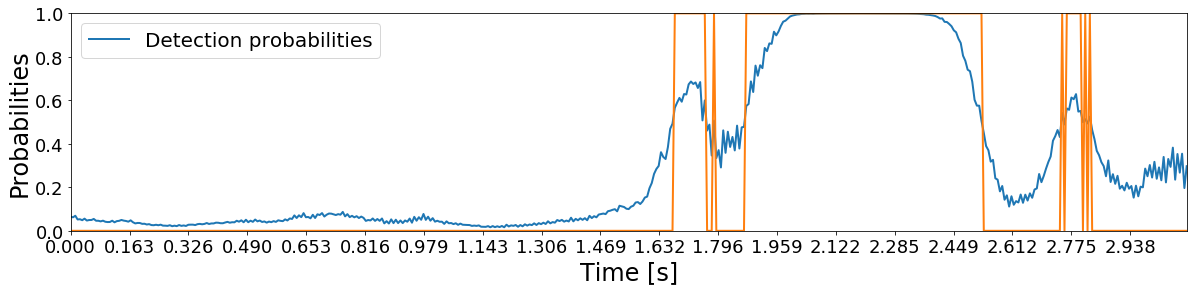

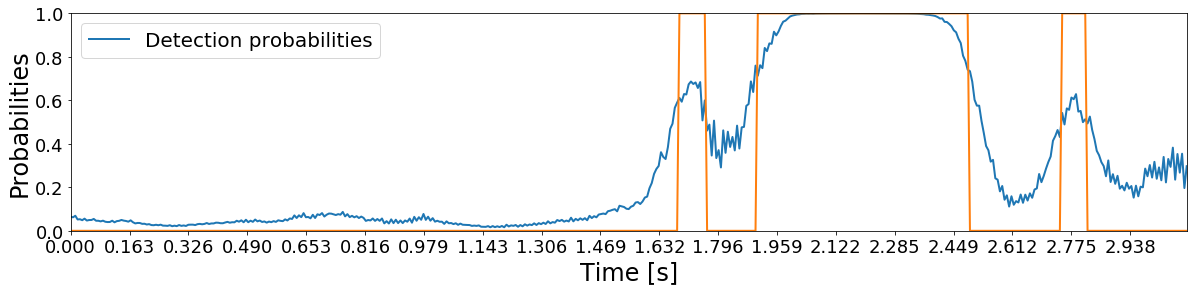

[['1.720' '0.687']
 ['1.778' '0.346']
 ['2.193' '1.000']
 ['2.743' '0.431']
 ['2.788' '0.629']
 ['2.807' '0.500']
 ['2.820' '0.494']]
[[1.7   0.687]
 [1.8   0.346]
 [2.2   1.   ]
 [2.7   0.431]
 [2.8   0.629]]
[[0.687 1.7   2.7   1.5   9.5  ]
 [0.346 1.8   2.8   1.5   9.5  ]
 [1.    2.2   3.2   1.5   9.5  ]
 [0.431 2.7   3.7   1.5   9.5  ]
 [0.629 2.8   3.8   1.5   9.5  ]]


In [130]:
# pulses = nn.detection_pulse(file, probs=probs, thresh=0.5)
# nn.plot_probabilities(file,probs=probs,font=font,pulses=[pulses])
# pulses = nn.detection_pulse(file, probs=probs, thresh=0.5, concav=True, concav_window=0.1,concav_error=-0.0)
# nn.plot_probabilities(file,probs=probs,font=font,pulses=[pulses])

# print(nn.detection_starting_locations(file, probs=probs, thresh=0.5, concav=False, concav_window=0.1,concav_error=-0.0))
# print(nn.detection_starting_locations_final(file, probs=probs, thresh=0.5, concav=False, concav_window=0.1,concav_error=-0.0))
# print(nn.detection_bounding_boxes(file, probs=probs, thresh=0.5, concav=False, concav_window=0.1,concav_error=-0.0))


In [109]:
# linewidth = 2
# font_title = 32
# font_legend = 20
# font_label = 24
# font_ticks = 18
# font = [font_title, font_legend, font_label, font_ticks, linewidth]

# file = np.random.choice(files)
# # file = '2013-07-03UT14:55:19.22531914.marion.vr2'
# # file = '2013-07-19UT04:14:42.00291922.marion.vr2'
# # print(file)
# probs = nn.detection_probabilities(file)